<a href="https://colab.research.google.com/github/NehaSontakk/RNA-sequencing-fastq-to-differential-gene-expression/blob/main/EdgeR_Normalization_190423.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge R normalization

Written by Neha Sontakke and aided by Akshara Dubey and Nitish Malhotra's Integrated Omics 3 course



Creating a directory to store your coverage files

In [7]:
dir.create(file.path("/content/data/"), showWarnings = FALSE)

### Installing softwares

In [4]:
install.packages("BiocManager")
install.packages("openxlsx")
library(openxlsx)
library(BiocManager)
BiocManager::install("edgeR")
library(edgeR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’


Old packages: 'bit', 'bslib', 'devtools', 'digest', 'gert', 'highr', 'isoband',
  'jsonlite', 'pkgload', 'roxygen2', 'tidyverse', 'usethis', 'whisker', 'boot',
  'foreign'

Loading required package: limma



**Loading the data**

In [ ]:
GenewiseCounts <- c()
Gene_coverage <- c()
X <- c()
index= 0
list_all = list.files("/content/data")
for (filename in list_all) {
  print(filename)
  index = index +1
  A <- read.table(paste("/content/data",filename, sep="/"),header = F,sep="\t")
  A <- A[!grepl("CCNA_R", A$V5),]
  Genes <- A$V5
  gene_name <- A$V5
  GenewiseCounts <- cbind(GenewiseCounts,A$V7)
}

[1] "delrecA_0_MMCandNF_Replicate1_AMJ.cov"
[1] "delrecA_0_MMCandNF_Replicate2_AMJ.cov"
[1] "delrecA_0hr_MMS_Replicate1_AK.cov"
[1] "delrecA_0hr_MMS_Replicate2_AK.cov"
[1] "delrecA_20_MMC_Replicate1.cov"
[1] "delrecA_20_MMC_Replicate2.cov"
[1] "delrecA_20_NF_Replicate1.cov"
[1] "delrecA_20_NF_Replicate2.cov"
[1] "delrecA_20mins_MMS_Replicate1.cov"
[1] "delrecA_20mins_MMS_Replicate2.cov"
[1] "delrecA_40_MMC_Replicate1.cov"
[1] "delrecA_40_MMC_Replicate2.cov"
[1] "delrecA_40_NF_Replicate1.cov"
[1] "delrecA_40_NF_Replicate2.cov"
[1] "delrecA_40mins_MMS_Replicate1.cov"
[1] "delrecA_40mins_MMS_Replicate2.cov"
[1] "WT_0_MMCandNF_Replicate1_AMJ.cov"
[1] "WT_0_MMCandNF_Replicate2_AMJ.cov"
[1] "WT_0hr_MMS_Replicate1_AK.cov"
[1] "WT_0hr_MMS_Replicate2_AK.cov"
[1] "WT_20_MMC_Replicate1.cov"
[1] "WT_20_MMC_Replicate2.cov"
[1] "WT_20_NF_Replicate1.cov"
[1] "WT_20_NF_Replicate2.cov"
[1] "WT_20mins_MMS_Replicate1.cov"
[1] "WT_20mins_MMS_Replicate2.cov"
[1] "WT_40_MMC_Replicate1.cov"
[1] "WT_40_MMC_Re

In [ ]:
rownames(GenewiseCounts) <- Genes

###  Specifying the names of the samples and number of files for that replicate

In [ ]:
colnames(GenewiseCounts) <- c(
paste(rep("delrecA_0",4),seq(1,4),sep = "_"),
paste(rep("delrecA_20_MMC",2),seq(1,2),sep = "_"),
paste(rep("delrecA_20_NF",2),seq(1,2),sep = "_"),
paste(rep("delrecA_20mins_MMS",2),seq(1,2),sep = "_"),
paste(rep("delrecA_40_MMC",2),seq(1,2),sep = "_"),
paste(rep("delrecA_40_NF",2),seq(1,2),sep = "_"),
paste(rep("delrecA_40mins_MMS",2),seq(1,2),sep = "_"),
paste(rep("WT_0",4),seq(1,4),sep = "_"),
paste(rep("WT_20_MMC",2),seq(1,2),sep = "_"),
paste(rep("WT_20_NF",2),seq(1,2),sep = "_"),
paste(rep("WT_20mins_MMS",2),seq(1,2),sep = "_"),
paste(rep("WT_40_MMC",2),seq(1,2),sep = "_"),
paste(rep("WT_40_NF",2),seq(1,2),sep = "_"),
paste(rep("WT_40mins_MMS",2),seq(1,2),sep = "_"))

### List of files with the replicates named as specified

In [ ]:
group<- c(rep("delrecA_0",4),rep("delrecA_20_MMC",2),rep("delrecA_20_NF",2),rep("delrecA_20mins_MMS",2),rep("delrecA_40_MMC",2),rep("delrecA_40_NF",2),rep("delrecA_40mins_MMS",2),rep("WT_0",4),rep("WT_20_MMC",2),rep("WT_20_NF",2),rep("WT_20mins_MMS",2),rep("WT_40_MMC",2),rep("WT_40_NF",2),rep("WT_40mins_MMS",2))
print(group)

 [1] "delrecA_0"          "delrecA_0"          "delrecA_0"         
 [4] "delrecA_0"          "delrecA_20_MMC"     "delrecA_20_MMC"    
 [7] "delrecA_20_NF"      "delrecA_20_NF"      "delrecA_20mins_MMS"
[10] "delrecA_20mins_MMS" "delrecA_40_MMC"     "delrecA_40_MMC"    
[13] "delrecA_40_NF"      "delrecA_40_NF"      "delrecA_40mins_MMS"
[16] "delrecA_40mins_MMS" "WT_0"               "WT_0"              
[19] "WT_0"               "WT_0"               "WT_20_MMC"         
[22] "WT_20_MMC"          "WT_20_NF"           "WT_20_NF"          
[25] "WT_20mins_MMS"      "WT_20mins_MMS"      "WT_40_MMC"         
[28] "WT_40_MMC"          "WT_40_NF"           "WT_40_NF"          
[31] "WT_40mins_MMS"      "WT_40mins_MMS"     


### Calculate the groups and library sizes for all samples and all replicates

In [ ]:
y<-DGEList(GenewiseCounts,group=group)
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
delrecA_0_1,delrecA_0,7828644,1
delrecA_0_2,delrecA_0,8058702,1
delrecA_0_3,delrecA_0,1874450,1
delrecA_0_4,delrecA_0,2353691,1
delrecA_20_MMC_1,delrecA_20_MMC,9210441,1
delrecA_20_MMC_2,delrecA_20_MMC,7897934,1
delrecA_20_NF_1,delrecA_20_NF,8257200,1
delrecA_20_NF_2,delrecA_20_NF,10361953,1
delrecA_20mins_MMS_1,delrecA_20mins_MMS,1650360,1


## MD Plots

of a single sample specified by column = 

A mean-difference plot (MD-plot) is a plot of log fold changes (differences) versus average log values (means). The history of mean-difference plots and MA-plots is reviewed in Ritchie et al (2015).

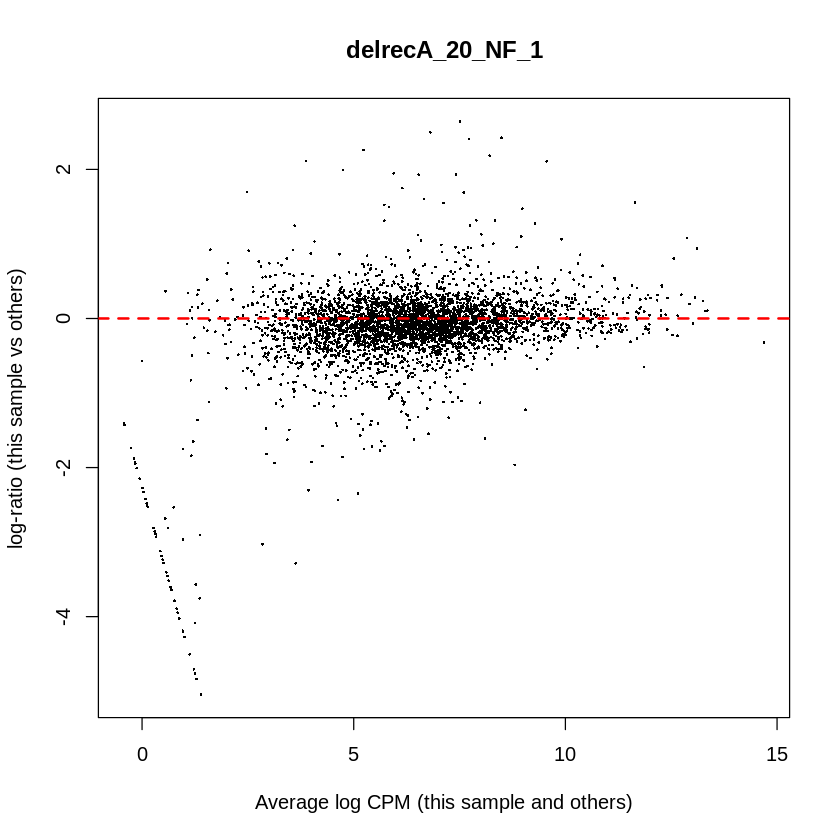

In [ ]:
plotMD(y,column=1)
abline(h=0,col="red",lty=2,lwd=2)

### Important step to calculate normalized data

In [ ]:
y<-calcNormFactors(y)

### Plotting the PCA

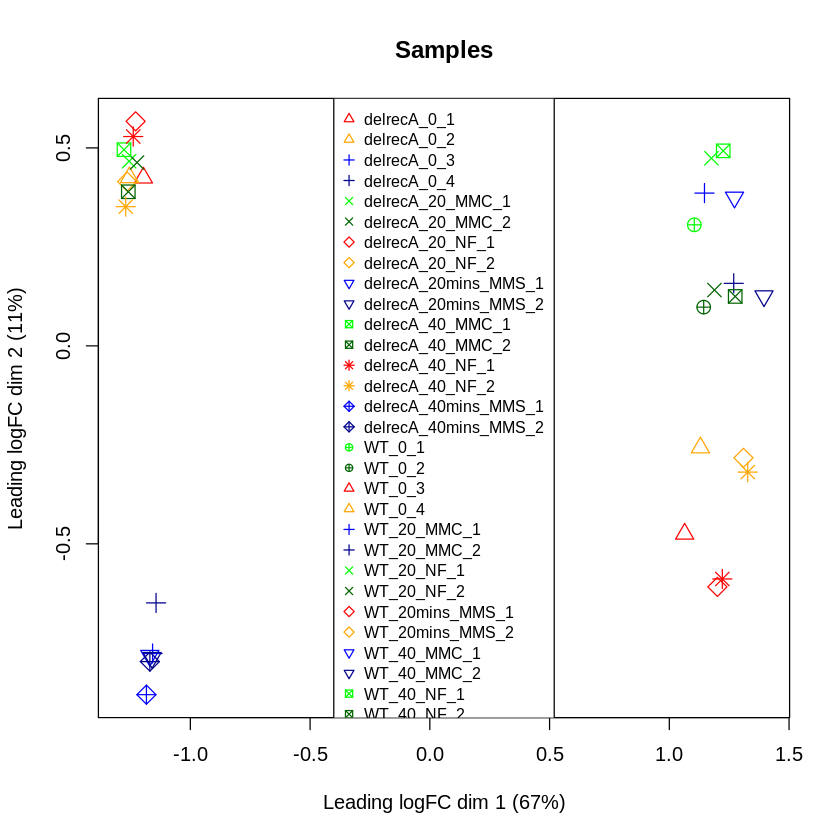

In [ ]:
#optional step to specify shapes and colors in the plot
pch<- c(rep(2,2),rep(3,2),rep(4,2),rep(5,2),rep(6,2),rep(7,2),rep(8,2),rep(9,2),rep(10,2))
colors<- c(rep("red",1),rep("orange",1),rep("blue",1),rep("dark blue",1),rep("green",1),rep("dark green",1))
plotMDS(y,col=colors,pch = pch,cex=1.5)
legend("top", legend=colnames(y), pch=pch, col=colors,ncol = 1,cex =0.8)
title("Sample Name")

### Make group matrix

In [ ]:
design <- model.matrix(~0+group)

In [ ]:
install.packages("statmod")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### estimateDisp: 
Estimate Common, Trended and Tagwise Negative Binomial dispersions by weighted likelihood empirical Bayes

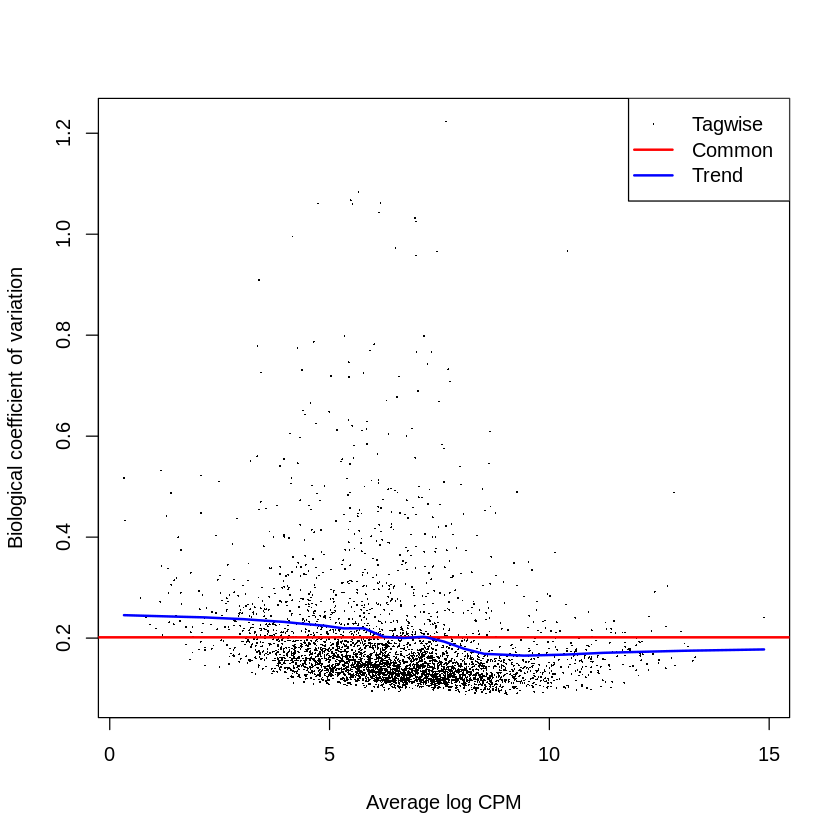

In [ ]:
y<-estimateDisp(y,design,robust=TRUE)
plotBCV(y)

### glmQLFit
Genewise Negative Binomial Generalized Linear Models with Quasi-likelihood Tests. Fit a quasi-likelihood negative binomial generalized log-linear model to count data. Conduct genewise statistical tests for a given coefficient or contrast. 

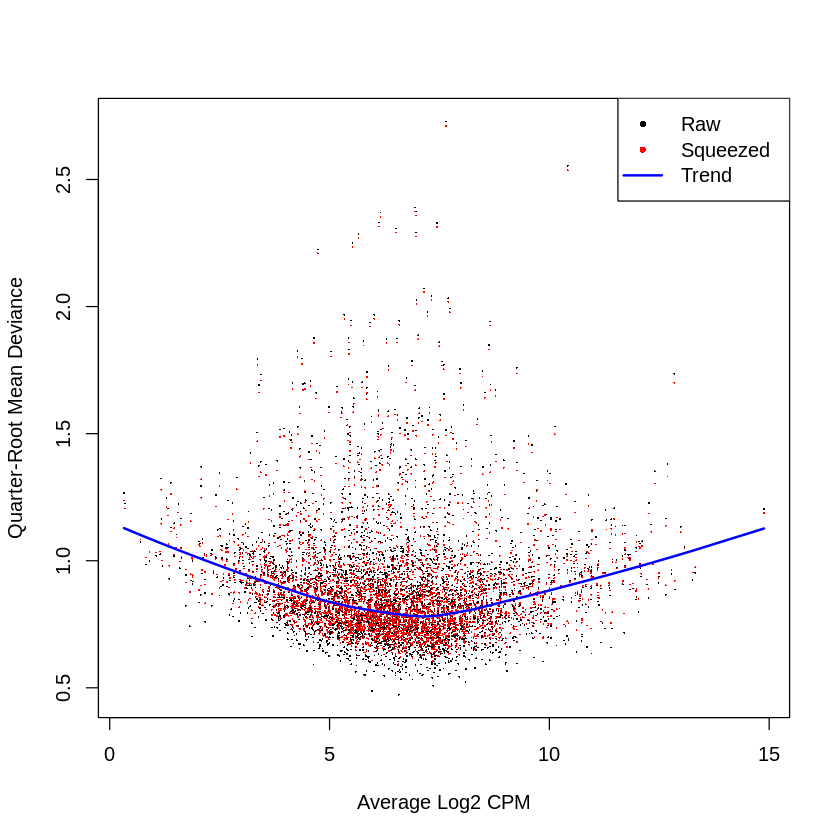

In [ ]:
fit<-glmQLFit(y,design,robust=TRUE)
plotQLDisp(fit)

### Count per million calculation

Computes counts per million (CPM) or reads per kilobase per million (RPKM) values.

In [ ]:
logCPM<-cpm(y,log=TRUE)
head(logCPM)
t_logCPM<-t(scale(t(logCPM)))

,delrecA_0_1,delrecA_0_2,delrecA_0_3,delrecA_0_4,delrecA_20_MMC_1,delrecA_20_MMC_2,delrecA_20_NF_1,delrecA_20_NF_2,delrecA_20mins_MMS_1,delrecA_20mins_MMS_2,⋯,WT_20_NF_1,WT_20_NF_2,WT_20mins_MMS_1,WT_20mins_MMS_2,WT_40_MMC_1,WT_40_MMC_2,WT_40_NF_1,WT_40_NF_2,WT_40mins_MMS_1,WT_40mins_MMS_2
CCNA_00001,6.867431,6.704424,6.910099,6.828338,6.808105,6.806041,6.841519,6.770673,6.965895,6.944877,⋯,6.980650,6.912846,7.067448,6.840786,6.787383,7.065008,6.933074,6.923476,6.930740,6.581570
CCNA_00002,6.319429,6.428657,6.611378,6.149483,6.442672,6.617776,6.441949,6.421602,6.526572,6.434017,⋯,6.499402,6.303137,6.398603,6.364465,6.374588,6.178992,6.535135,6.371451,6.300170,6.520041
CCNA_00003,6.487856,6.407069,6.320029,6.268293,6.505804,6.538424,6.523317,6.549597,6.256252,6.230587,⋯,6.660899,6.537179,6.473955,6.399314,6.515132,6.301529,6.670465,6.557430,6.283061,6.618735
CCNA_00004,6.091719,6.189811,6.032895,5.877749,6.342472,6.267965,6.232890,6.486229,6.099372,5.847937,⋯,6.325805,6.171421,5.885332,6.072217,6.175036,5.968217,6.311611,6.137918,5.696606,6.145313
CCNA_00005,7.285632,7.147109,7.503050,7.280607,7.340734,7.338866,7.297454,7.272834,7.569765,7.456845,⋯,7.537963,7.368226,7.399232,7.339549,7.166685,7.257965,7.739933,7.440700,7.392188,7.058134
CCNA_00006,7.850872,7.646469,7.484585,7.215062,7.717808,7.635192,7.820420,7.660107,7.633145,7.344864,⋯,7.931756,7.634529,7.285312,7.418117,7.737420,7.430820,7.920313,7.553597,7.396171,7.537197


### Ouput file for all the CPM normalised reads (THIS IS NOT THE END!)

In [ ]:
table_for_norm_reads <- as.data.frame(logCPM)

In [ ]:
write.xlsx(table_for_norm_reads,"logCPM_normalised_reads.xlsx")

### Calculate edgeR normalisation now

In [ ]:
install.packages("psych")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘mnormt’




## Comparative Group definition (requires user input)

In [ ]:
comparisons<-c("groupdelrecA_20_MMC-groupdelrecA_0","groupdelrecA_40_MMC-groupdelrecA_0","groupdelrecA_20_NF-groupdelrecA_0","groupdelrecA_40_NF-groupdelrecA_0","groupdelrecA_20mins_MMS-groupdelrecA_0","groupdelrecA_40mins_MMS-groupdelrecA_0","groupWT_20_MMC-groupWT_0","groupWT_40_MMC-groupWT_0","groupWT_20_NF-groupWT_0","groupWT_40_NF-groupWT_0","groupWT_20mins_MMS-groupWT_0","groupWT_40mins_MMS-groupWT_0")

### Number of comparisons to be made (as specified above)

In [ ]:
length(comparisons)

[1] 12

### Code below generates log fold change files for all comparisons specified above

In [ ]:
for (i in 1:length(comparisons)) {
  x = comparisons[i] #for all groups specified above
  print(x)
  mvsw<-makeContrasts(x,levels=design)
  res<-glmQLFTest(fit,contrast=mvsw)
  W<- topTags(res,n = nrow(res$table))
  print(head(W))
  name_of_df <- paste("/content/Log_fold_change_and_normalised_CPM_values/",x,"_LFC_edgeR_normalised.xlsx")
  write.xlsx(W$table,name_of_df,colNames=TRUE, rowNames=TRUE)
}

[1] "groupdelrecA_20_MMC-groupdelrecA_0"
Coefficient:  -1*groupdelrecA_0 1*groupdelrecA_20_MMC 
                logFC   logCPM        F       PValue       FDR
CCNA_00722  1.3452995 9.897895 22.81706 9.053537e-05 0.2438360
CCNA_00296 -1.2207688 6.439209 20.25687 1.659899e-04 0.2438360
CCNA_00297 -1.0155181 5.880649 19.68151 1.882419e-04 0.2438360
CCNA_00295 -1.2891230 6.453647 18.45980 2.900723e-04 0.2818052
CCNA_00293 -1.6653607 7.512529 18.17570 3.638268e-04 0.2827662
CCNA_02925 -0.4975541 8.791021 14.41159 9.269805e-04 0.4916020
[1] "groupdelrecA_40_MMC-groupdelrecA_0"
Coefficient:  -1*groupdelrecA_0 1*groupdelrecA_40_MMC 
               logFC   logCPM        F       PValue          FDR
CCNA_02397 1.3385306 6.317537 61.83384 5.604090e-08 0.0002177749
CCNA_00276 1.3585807 6.144072 48.89876 3.894693e-07 0.0005952806
CCNA_01149 1.4722985 7.230268 47.89261 4.595579e-07 0.0005952806
CCNA_02396 1.3796607 7.982321 44.39840 8.323592e-07 0.0008086369
CCNA_00722 1.5197890 9.897895 29.24812 1.9

In [ ]:
#x = comparisons[1] #for first comparative group
#mvsw<-makeContrasts(x,levels=design)
#res<-glmQLFTest(fit,contrast=mvsw)
#W<- topTags(res,n = nrow(res$table))
#write.xlsx(W,"delrecA_20_LFC_edgeR_normalised_for_Figure1.xlsx")
#head(W)
#with(W$table, plot(logFC, -log10(PValue), pch=20, main="Volcano plot",col=ifelse((FDR <= 0.05 & abs(logFC) >= log2(2)),"red","black")))
#legend("topleft", legend=c("|logFC| >= log2(2) & pvalue<= 0.05","|logFC| < log2(2) or pvalue >0.05"), pch=c(20,20), col=c("red","black"), ncol = 1,cex = 0.8)

In [ ]:
system("zip -r /content/Log_fold_change_and_normalised_CPM_values.zip /content/Log_fold_change_and_normalised_CPM_values/")

In [ ]:
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.3                         
year           2023                        
month          03                          
day            15                          
svn rev        83980                       
language       R                           
version.string R version 4.2.3 (2023-03-15)
nickname       Shortstop Beagle            